In [1]:
import numpy as np
import pandas as pd
import time
import sys
import tqdm
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import math
import random
import scipy
from scipy.optimize import curve_fit
import scipy.optimize as op
import matplotlib.colors as colors

from numba import njit, objmode
from tqdm import tqdm, trange

from multihist import Histdd

import logging
logging.getLogger('hax.minitrees').setLevel(logging.INFO)

#from lax.lichen import Lichen
#import lichens as se_cuts

In [2]:
params = {
    'font.family': 'serif',
    'font.size' : 24, 'axes.titlesize' : 42, 'axes.labelsize' : 32, 'axes.linewidth' : 2,
    # ticks
    'xtick.labelsize' : 24, 'ytick.labelsize' : 24, 'xtick.major.size' : 16, 'xtick.minor.size' : 8,
    'ytick.major.size' : 16, 'ytick.minor.size' : 8, 'xtick.major.width' : 2, 'xtick.minor.width' : 2,
    'ytick.major.width' : 2, 'ytick.minor.width' : 2, 'xtick.direction' : 'in', 'ytick.direction' : 'in',
    # markers
    'lines.markersize' : 8, 'lines.markeredgewidth' : 2, 'errorbar.capsize' : 5, 'lines.linewidth' : 2,
    #'lines.linestyle' : None, 'lines.marker' : None,
    'savefig.bbox' : 'tight', 'legend.fontsize' : 24,
    'axes.labelsize': 24, 'axes.titlesize':24, 'xtick.labelsize':18, 'ytick.labelsize':18,
    'backend': 'Agg', 'mathtext.fontset': 'dejavuserif',
    'figure.facecolor':'w',
    #pad
    'axes.labelpad':12,
    # ticks
    'xtick.major.pad': 6,   'xtick.minor.pad': 6,   
    'ytick.major.pad': 3.5, 'ytick.minor.pad': 3.5,
}
plt.rcParams.update(params)

In [3]:
xenon_density = 0.002862 #kg/cm^3 
#z = tpc_height # cm
time_ns_to_s = 1/1e9 # s
time_s_to_days = 1/60/60/24 # days
mass_kg_to_tonne = 1/1000 # tonne

drift_velocity = 1 # mm/us
x_mm_to_cm = 1/10 # cm
time_ns_to_us = 1/1000 # us

## Loading data and some preliminary checks

In [4]:
data_peak = np.load('/project2/lgrandi/ghusheng/sr0_10runs_peak_basics.npy')
data_peak = pd.DataFrame(data_peak)

In [5]:
### These functions were developed by Juehang Qin

@njit
def shadow_area(area, delta_times, overlap_cut_time_s):
    """
    Calculates the shadow area of an object with given area and time delay.

    Parameters:
    area (float): The area of the current peak.
    delta_times (float): The time delay between the current peak and subsequent peaks.
    overlap_cut_time_s (float, optional): The overlap cut time constant in seconds. Default is `overlap_cut_time_s`.

    Returns:
    float: The shadow area of the object.

    """
    return area * np.exp(-delta_times / overlap_cut_time_s)

@njit
def window_loop_func(time_diff_ns, overlap_cut_time_s, overlap_cut_max_times, last_index, current_time, N, primary_times_int):
    """
    This function takes in several parameters including the time difference in nanoseconds, 
    the overlap cut time in seconds, the maximum allowed overlaps, the last index, the current time,
    and the total number of elements. It then iterates through a while loop, incrementing the last index
    and updating the time difference until the time difference exceeds the limit set by the overlap cut time 
    multiplied by the maximum allowed overlaps or the last index becomes greater than or equal to N-2.
    The function returns the updated last index and time difference.
    """
    while time_diff_ns * 1e-9 < overlap_cut_time_s * overlap_cut_max_times and last_index < N-2:
        last_index += 1
        time_diff_ns = primary_times_int[last_index] - current_time
    return last_index, time_diff_ns


def peaks_to_reject(primary_areas, primary_times_int, overlap_cut_time_s, overlap_cut_max_times, overlap_cut_ratio):
    """
    Reject peaks that overlap with other peaks based on their areas.
    
    Args:
        primary_areas (numpy.ndarray): 1D array of peak areas.
        primary_times_int (numpy.ndarray): 1D array of corresponding peak times in nanoseconds.
        overlap_cut_time_s (float): Time constant for exponential overlap cut. Default is `overlap_cut_time_s`.
        overlap_cut_max_times (int): Number of overlap cut time constants to look for. Default is `overlap_cut_max_times`.
        overlap_cut_ratio (float): Ratio of shadow area to primary area that determines if a peak should be rejected. Default is `overlap_cut_ratio`.
    
    Returns:
        numpy.ndarray: 1D array of peak times in nanoseconds that are rejected.
    """
    N = len(primary_areas)
    shadow_areas_arr = np.zeros_like(primary_areas)
    for i in trange(0, N-1):
        current_area = primary_areas[i]
        current_time = primary_times_int[i]
        last_index = i+1
        time_diff_ns = primary_times_int[last_index] - current_time
        
        last_index, time_diff_ns = window_loop_func(time_diff_ns, overlap_cut_time_s, overlap_cut_max_times, last_index, current_time, N, primary_times_int)
        
        shadow_areas_arr[i+1: last_index+1] += shadow_area(current_area, (primary_times_int[i+1: last_index+1] - current_time)*1e-9, overlap_cut_time_s=overlap_cut_time_s)
    rejection_bool = primary_areas*overlap_cut_ratio < shadow_areas_arr
    return np.array(primary_times_int[rejection_bool])

def get_windows(primaries, selected_peaks, overlap_cut_time_s, overlap_cut_max_times, overlap_cut_ratio):
    """
    Computes the window lengths for a set of selected primary peaks.

    Parameters:
    -----------
    primaries: pandas.DataFrame
        A DataFrame containing all primary peaks.
    selected_peaks: pandas.DataFrame
        A DataFrame containing the selected primary peaks.
    overlap_cut_time_s: float, optional (default: overlap_cut_time_s)
        The maximum time overlap between two peaks, in seconds.
    overlap_cut_max_times: int, optional (default: overlap_cut_max_times)
        The maximum number of overlaps allowed between two peaks.

    Returns:
    --------
    window_lengths: list of floats
        A list of window lengths (in seconds) for each peak in selected_peaks.
    """
    window_lengths = []
    N = len(selected_peaks)
    for row in tqdm(selected_peaks.iterrows(), total=N):
        current_time = row[1]['time']
        current_area = row[1]['area']
        primaries_in_shadow = primaries.query('time > @current_time and time < @current_time + @overlap_cut_time_s*@overlap_cut_max_times*1e9')
        delta_times_ns = primaries_in_shadow['time'].values - current_time
        shadow_areas = shadow_area(current_area, delta_times_ns*1e-9, overlap_cut_time_s=overlap_cut_time_s)
        window_end_bool = shadow_areas*overlap_cut_ratio < primaries_in_shadow['area'].values
        peaks_outside_window = delta_times_ns[window_end_bool]
        if len(peaks_outside_window):
            window_lengths.append(np.min(peaks_outside_window)*1e-9)
        else:
            window_lengths.append(0)
    return window_lengths

@njit
def lone_hit_window_loop_func(data_lone_hits_times, start_time_loop, N_lh, end_time_loop, start_index, end_index):
    while data_lone_hits_times[start_index] < start_time_loop and start_index<N_lh-1000:
        start_index += 1000
    start_index -= 1000
    while data_lone_hits_times[end_index] < end_time_loop and start_index<N_lh-1000:
        end_index += 1000
    return start_index, end_index

def get_lone_hit_times(selected_peaks, window_lengths, data_lone_hits):
    """
    Extracts the lone hit times, time differences and primary areas for a given set
    of selected peaks and associated window lengths.

    Args:
    - selected_peaks (pandas.DataFrame): a DataFrame with peak information, including
        the 'time' and 'area' columns.
    - window_lengths (list-like): a list or array of window lengths, in seconds,
        associated with each peak.
    - data_lone_hits (pandas.DataFrame): a DataFrame with lone hit information, 
        including the 'time' column.

    Returns:
    - tuple: a tuple of three arrays, containing the lone hit times (in seconds), 
        the time differences with respect to the start of each peak window (in seconds),
        and the primary areas associated with each peak. 

    This function works by iterating over the selected peaks and their associated
    windows, finding all lone hits that fall within each window and extracting their 
    times, time differences and primary areas. The output is returned as a tuple of 
    arrays, with one entry per lone hit found across all windows.
    """
    i = 0
    lone_hit_times = []
    lone_hit_dts = []
    lone_hit_channel = []
    primary_index = []
    N_lh = len(data_lone_hits)
    data_lone_hits_times = data_lone_hits['time'].values
    for row in tqdm(selected_peaks.iterrows(), total=len(selected_peaks)):
        start_time_loop = row[1]['time']
        end_time_loop = row[1]['time'] + window_lengths[i]*1e9
        start_index = 0
        end_index = 0
        start_index, end_index = lone_hit_window_loop_func(data_lone_hits_times, start_time_loop, N_lh, end_time_loop, start_index, end_index)
        this_loop_lonehits = data_lone_hits.iloc[start_index:end_index].query('time < @end_time_loop and time > @start_time_loop')
        lone_hit_times.extend(this_loop_lonehits['time'].values)
        lone_hit_dts.extend(this_loop_lonehits['time'].values - start_time_loop)
        lone_hit_channel.extend(this_loop_lonehits['channel'].values)                
        primary_index.extend([row[0]]*len(this_loop_lonehits))
        i+=1
    return lone_hit_times, lone_hit_dts, lone_hit_channel, primary_index

def get_S2s_times(selected_peaks, window_lengths, peaks):
    """
    Extracts the lone hit times, time differences and primary areas for a given set
    of selected peaks and associated window lengths.

    Args:
    - selected_peaks (pandas.DataFrame): a DataFrame with peak information, including
        the 'time' and 'area' columns.
    - window_lengths (list-like): a list or array of window lengths, in seconds,
        associated with each peak.
    - data_lone_hits (pandas.DataFrame): a DataFrame with lone hit information, 
        including the 'time' column.

    Returns:
    - tuple: a tuple of three arrays, containing the lone hit times (in seconds), 
        the time differences with respect to the start of each peak window (in seconds),
        and the primary areas associated with each peak. 

    This function works by iterating over the selected peaks and their associated
    windows, finding all lone hits that fall within each window and extracting their 
    times, time differences and primary areas. The output is returned as a tuple of 
    arrays, with one entry per lone hit found across all windows.
    """
    i = 0
    s2_index = []
    s2_dts = []
    primary_index = []
    N_peak = len(peaks)
    peak_times = peaks['time'].values
    for row in tqdm(selected_peaks.iterrows(), total=len(selected_peaks)):
        start_time_loop = row[1]['time']
        end_time_loop = row[1]['time'] + window_lengths[i]*1e9
        start_index = 0
        end_index = 0
        start_index, end_index = lone_hit_window_loop_func(peak_times, start_time_loop, N_peak, end_time_loop, start_index, end_index)
        this_loop_peaks = peaks.iloc[start_index:end_index].query('time < @end_time_loop and time > @start_time_loop')
        s2_index.extend(this_loop_peaks.index)
        s2_dts.extend(this_loop_peaks['time'].values - start_time_loop)
        primary_index.extend([row[0]]*len(this_loop_peaks))
        i+=1
    return s2_index, s2_dts, primary_index

@njit
def histogram_with_weights_innerloop(unique_weights, weights_in_bin):
    poisson_numbers = []
    for unique_weight in unique_weights:
        poisson_numbers.append(np.sum(weights_in_bin == unique_weight))
    return poisson_numbers

def histogram_with_weights(items, weights, bins):
    """
    Computes a weighted histogram of a set of items with estimated Gaussian errorbars, using a given set of bin edges.

    Args:
    - items (list-like): a list or array of numerical values to be binned.
    - weights (list-like): a list or array of non-negative weights associated with each item.
    - bins (list-like): a list or array of bin edges (in seconds), defining the boundaries
        of each histogram bin.

    Returns:
    - tuple: a tuple of two arrays, containing the weighted histogram and the corresponding
        errors for each bin.

    This function works by first computing the bin number for each item, based on its value
    and the bin edges provided. It then groups the items and their corresponding weights by 
    bin number, and computes a Poisson error estimate for each unique weight value in each bin,
    using the number of occurrences of that value. Finally, it normalizes the sum of weights 
    within each bin by the width of the bin, and returns the resulting weighted histogram
    and error estimates as separate arrays.

    Note that the input items and the output histogram are assumed to be in units of seconds,
    while the input weights are unitless. The function uses numpy arrays and operations for 
    efficient computation and vectorization.
    """

    N = len(bins) - 1
    bin_widths = np.diff(bins)
    bin_numbers = np.searchsorted(bins, np.array(items)*1e-9, side='right')-1
    weighted_histogram = []
    errors = []
    for i in trange(0, N):
        items_in_bin = items[bin_numbers == i]
        weights_in_bin = weights[bin_numbers == i]
        unique_weights = np.unique(weights_in_bin)
        poisson_numbers = histogram_with_weights_innerloop(unique_weights, weights_in_bin)
        error = np.sqrt(np.sum(poisson_numbers*unique_weights**2))
        summed_weights = np.sum(weights_in_bin)
        weighted_histogram.append(summed_weights)
        errors.append(error)
    return np.array(weighted_histogram)/bin_widths, np.array(errors)/bin_widths

In [6]:
min_primary_size_PE = 1000 #min size of primary peaks (PE)
overlap_cut_time_s = 3e-1 #the time constant for exponential overlap cut, https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:xenon1t:adepoian:overlapcut_overview
overlap_cut_ratio = 0.1 #peaks are only accepted if all previous primary peaks multiplied by (t/drift_time)^(overlap_cut_power) is less than overlap_cut_ratio of the current peak
overlap_cut_max_times = 30 #number of time constants to consider previous peaks for overlap cut
max_drift_time_s = 2.5e-3 #s
edge_time_discard_s = 1 #s, discard the first and last few seconds of data because it is unknown if there's overlap from earlier, and the last few peaks won't have proper trains.
SE_gain = 31 #https://xe1t-wiki.lngs.infn.it/doku.php?id=xenon:abby:segain_evolution

In [7]:
rejected_peak_times = peaks_to_reject(data_peak[data_peak['area']>80]['area'].values, data_peak[data_peak['area']>80]['time'].values, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)

100%|██████████| 2285757/2285757 [00:58<00:00, 39321.82it/s]


In [8]:
data_lh = np.load('/project2/lgrandi/ghusheng/sr0_10runs_lone_hits.npy')
data_lh = pd.DataFrame({
    'time': data_lh['time'],
    'channel': data_lh['channel']
})

In [9]:
# limiting the data to the time of lonehits
start_time = data_lh['time'].min()
end_time = data_lh['time'].max()
selected_peaks = data_peak.query('time not in @rejected_peak_times and area>@min_primary_size_PE and time > @start_time + @edge_time_discard_s*1e9 and time < @end_time - @edge_time_discard_s*1e9')

In [10]:
selected_peaks = selected_peaks[selected_peaks['type']==2]

In [11]:
%matplotlib inline

## AFT Cut for selecting primaries in liquid

In [12]:
def lower_boundary(cs2_wo_elifecorr):
    # Create an array to store the results
    cs2_area_fraction_top = np.zeros_like(cs2_wo_elifecorr)

    # Apply conditions using boolean indexing
    mask1 = cs2_wo_elifecorr < 1E5
    mask2 = (cs2_wo_elifecorr >= 1E5) & (cs2_wo_elifecorr < 1E6)
    mask3 = cs2_wo_elifecorr >= 1E6

    # Element-wise operations for each condition
    cs2_area_fraction_top[mask1] = 0.7484 - 1.8565 / np.sqrt(cs2_wo_elifecorr[mask1])
    cs2_area_fraction_top[mask2] = 0.7484 - 1.8565 / np.sqrt(1E5)
    cs2_area_fraction_top[mask3] = 0

    return cs2_area_fraction_top
    
def upper_boundary(cs2_wo_elifecorr):
    # Create an array to store the results
    cs2_area_fraction_top = np.zeros_like(cs2_wo_elifecorr)

    # Apply conditions using boolean indexing
    mask1 = cs2_wo_elifecorr < 1E5
    mask2 = cs2_wo_elifecorr >= 1E5

    # Element-wise operations for each condition
    cs2_area_fraction_top[mask1] = 0.7523 + 1.7887 / np.sqrt(cs2_wo_elifecorr[mask1])
    cs2_area_fraction_top[mask2] = 0.7523 + 1.7887 / np.sqrt(1E5)

    return cs2_area_fraction_top

In [13]:
cs2_wo_elifecorr = np.logspace(2,7,150)
aft_low = lower_boundary(cs2_wo_elifecorr)
aft_high = upper_boundary(cs2_wo_elifecorr)

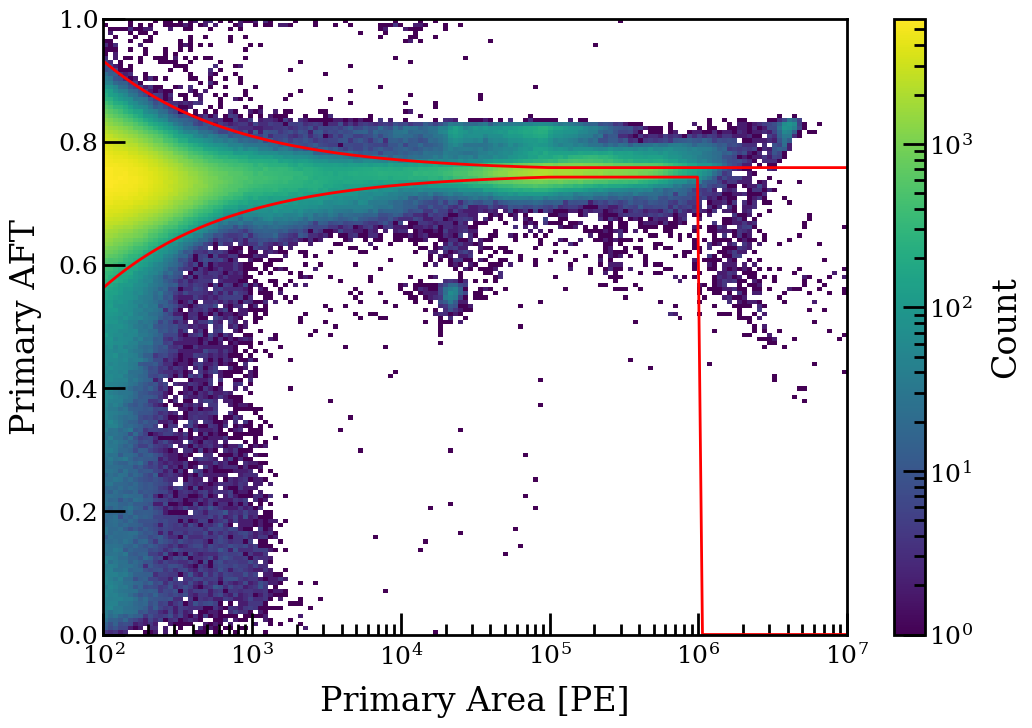

In [14]:
f = plt.figure(figsize=(12,8))

m2 = Histdd(data_peak[data_peak['type']==2]['area'].values,
            data_peak[data_peak['type']==2]['area_fraction_top'].values,
            bins=[np.logspace(2,7,150),np.linspace(0,1,150)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')
plt.plot(cs2_wo_elifecorr, aft_low, color='r')
plt.plot(cs2_wo_elifecorr, aft_high, color='r')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Primary Area [PE]')
plt.ylabel('Primary AFT')
plt.show()

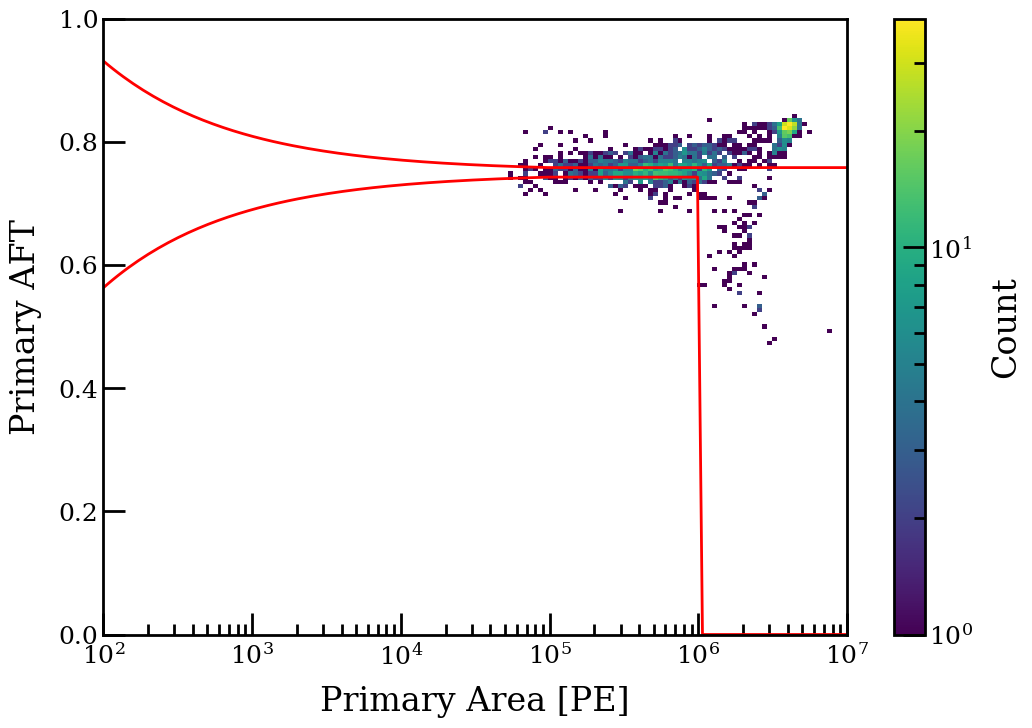

In [15]:
f = plt.figure(figsize=(12,8))

m2 = Histdd(selected_peaks[selected_peaks['type']==2]['area'].values,
            selected_peaks[selected_peaks['type']==2]['area_fraction_top'].values,
            bins=[np.logspace(2,7,150),np.linspace(0,1,150)])

m2.plot(cblabel = 'Count', log_scale = True, cmap = 'viridis')
plt.plot(cs2_wo_elifecorr, aft_low, color='r')
plt.plot(cs2_wo_elifecorr, aft_high, color='r')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Primary Area [PE]')
plt.ylabel('Primary AFT')
plt.show()

In [16]:
selected_peaks = selected_peaks[selected_peaks['area_fraction_top']<upper_boundary(selected_peaks['area'])]
selected_peaks = selected_peaks[selected_peaks['area_fraction_top']>lower_boundary(selected_peaks['area'])]

In [18]:
len(selected_peaks)

616

In [19]:
selected_peaks['window_lengths'] = get_windows(data_peak, selected_peaks, overlap_cut_time_s=overlap_cut_time_s, overlap_cut_max_times=overlap_cut_max_times, overlap_cut_ratio=overlap_cut_ratio)
selected_peaks = selected_peaks[selected_peaks['window_lengths']>0.025]

100%|██████████| 616/616 [01:22<00:00,  7.48it/s]


In [21]:
lone_hit_times, lone_hit_dts, lone_hit_channel, primary_index = get_lone_hit_times(selected_peaks, selected_peaks['window_lengths'].values, data_lh)
del data_lh
df = pd.DataFrame({
            'time': lone_hit_times,
            'lone_hit_channel': lone_hit_channel,
            'dt_primary':lone_hit_dts,
            'primary_index': primary_index,
            'type':0
        })

100%|██████████| 405/405 [00:02<00:00, 149.12it/s]


In [22]:
s2_index, s2_dts, primary_index = get_S2s_times(selected_peaks, selected_peaks['window_lengths'].values, data_peak)


100%|██████████| 405/405 [00:01<00:00, 273.26it/s]


In [23]:
data = data_peak.iloc[s2_index]
del data_peak
data['dt_primary'] = s2_dts
data['primary_index'] = primary_index
data = data[data['type'] != 0]

In [24]:
df = pd.concat([df, data], axis=0)
del data

In [25]:
df = df.sort_values('time')
df = df.reset_index(drop=True)

### Also removing events within 6 microseconds of single-electrons
Amanda/single_photons/lonehits_gas.ipynb

In [26]:
time = 6000  # 6 microseconds 
times_col = df['time'].values
type_col = df['type'].values
maxtime = max(times_col)
drop_this = []

for i in trange((len(df)-1)):
    if type_col[i] == 2:
        time1 = times_col[i]
        time2 = time1 + time
        if time2 > maxtime:
            time2 = maxtime
        start = i + 1
        end = i + 20 
        if start >= (len(df)-1):
            start = len(df)-1
        if end >= (len(df)-1):
            end = len(df)-1
        for n in range(start, end):
            if ((type_col[n] == 0) &(times_col[n] > time1) & (times_col[n] < time2)):
                drop_this.append(n)

100%|██████████| 2069590/2069590 [00:01<00:00, 1375591.01it/s]


In [27]:
df = df.drop(df.index[drop_this])

In [28]:
del times_col, type_col, drop_this

In [41]:
primary_index_to_remove = df.groupby('primary_index')['dt_primary'].min()
primary_index_to_remove = primary_index_to_remove[primary_index_to_remove > 1e6].index

# Step 2: Remove rows corresponding to those primary_index values
df = df[~df['primary_index'].isin(primary_index_to_remove)]

In [42]:
df_sp = df[df['type']==0]

100%|██████████| 99/99 [00:00<00:00, 505.17it/s]


<Figure size 1400x600 with 0 Axes>

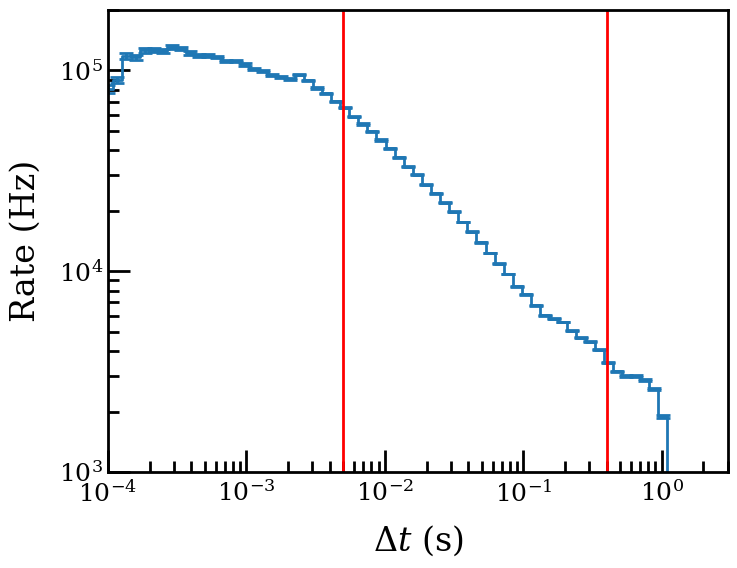

In [49]:
sorted_windows = np.sort(selected_peaks['window_lengths']) #sort window lengths
window_bins_edges = np.concatenate([[0], sorted_windows]) #define windows bins
number_of_overlapping_bins = np.arange(len(window_bins_edges)-1, 0, -1) 
weights = 1/number_of_overlapping_bins #scale bins

lone_hit_weights = weights[np.searchsorted(window_bins_edges, np.array(df_sp['dt_primary'])*1e-9, side='right')-1]
histogram_bins = np.logspace(-6, 0.5, 100)
log_histogram_bins = np.linspace(-6, 0.5, 100)
weighted_hist, hist_errs = histogram_with_weights(np.array(df_sp['dt_primary']), np.array(lone_hit_weights), histogram_bins)
fig = plt.figure(figsize=(14, 6))

xlim=[1e-4, 3]
ylim=[1e3, 2e5]
error_locations = 10**(log_histogram_bins[:-1] + np.diff(log_histogram_bins)/2) #np.diff
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111)
ax.step(histogram_bins, np.concatenate([weighted_hist, [weighted_hist[-1]]]), where='post') #for bin width
ax.errorbar(error_locations, weighted_hist, yerr=hist_errs, fmt='none', label='data (20 sigma error bars)')
#ax.plot(histogram_bins, 2e3*histogram_bins**(-0.72), label='slope = -0.72')
#ax.vlines(x=[max_drift_time_s], ymin=ylim[0], ymax=ylim[1], color='k', linestyle=':')
ax.set(xscale='log', yscale='log', xlim=xlim, ylim=ylim, xlabel='$\Delta t$ (s)', ylabel='Rate (Hz)')
plt.axvline(0.005,color='r')
plt.axvline(0.4,color='r')
#ax.legend()
plt.savefig('single-photon train.png')
plt.show()


## Single electron background

In [ ]:
df_se = df[df['type']==0]